In [1]:
from codecarbon import EmissionsTracker
# Iniciar el medidor
tracker = EmissionsTracker()
tracker.start()

[codecarbon INFO @ 18:14:54] [setup] RAM Tracking...
[codecarbon INFO @ 18:14:54] [setup] CPU Tracking...
[codecarbon WARNING @ 18:14:57] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 18:14:59] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 18:14:59] [setup] GPU Tracking...
[codecarbon INFO @ 18:14:59] No GPU found.
[codecarbon INFO @ 18:14:59] >>> Tracker's metadata:
[codecarbon INFO @ 18:14:59]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 18:14:59]   Python version: 3.9.12
[codecarbon INFO @ 18:14:59]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 18:14:59]   Available RAM : 8.000 GB
[codecarbon INFO @ 18:14:59]   CPU count: 8
[codecarbon INFO @ 18:14:59]   CPU model: Apple M1
[codecarbon INFO @ 18:14:59]   GPU count: None
[codecarbon INFO @ 18:14:59]   GPU model: None
[codecarbon INFO @ 18:15:00] Saving emissions data to

[codecarbon INFO @ 18:15:15] Energy consumed for RAM : 0.000013 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:15:15] Energy consumed for all CPUs : 0.000021 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:15:15] 0.000033 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:30] Energy consumed for RAM : 0.000025 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:15:30] Energy consumed for all CPUs : 0.000042 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:15:30] 0.000067 kWh of electricity used since the beginning.


In [2]:
import torch
import matplotlib
import sklearn
import moviepy

In [3]:
import pandas as pd
import numpy as np

# Cargar el dataset original
df = pd.read_csv("/Users/lucia/.cache/kagglehub/datasets/trisha2094/weatheraus/versions/1/weatherAUS.csv")

# Convertir 'RainTomorrow' a numérico
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})


In [4]:
import torch
from kan import *
import matplotlib.pyplot as plt
import moviepy.video.io.ImageSequenceClip

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [5]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def load_weather_dataset(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Drop 'RISK_MM' column (data leakage)
    df.drop(['RISK_MM'], axis=1, inplace=True)

    # Convert 'Date' to datetime and extract year, month, day
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    # Drop original 'Date' column
    df.drop('Date', axis=1, inplace=True)

    # Handle 'RainToday' & 'RainTomorrow'
    df['RainToday'].fillna('No', inplace=True)  
    df['RainTomorrow'].fillna('No', inplace=True)  # Assume 'No' if missing

    df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1}).astype(int)
    df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(int)  # Target variable

    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()

    # Ensure 'RainTomorrow' is NOT treated as a feature
    num_cols.remove('RainTomorrow') if 'RainTomorrow' in num_cols else None
    cat_cols.remove('RainTomorrow') if 'RainTomorrow' in cat_cols else None

    # Fill missing values
    for col in num_cols:
        df[col].fillna(df[col].mean(), inplace=True)  # Replace missing numerical values with mean

    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)  # Replace missing categorical values with most frequent category

    # Encode categorical features
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store encoders for inverse transformation

    # Select feature columns (all except the target)
    feature_columns = num_cols + cat_cols
    target_column = 'RainTomorrow'

    # Extract data and target
    data = df[feature_columns].values
    target = df[target_column].values

    # Apply MinMaxScaler to scale numerical features to range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(
        data_tensor, target_tensor, test_size=0.2, random_state=42
    )

    # Create PyTorch dataloaders
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False
    )

    # Create empty tensors
    train_inputs = torch.empty(0, len(feature_columns), device='cpu')
    train_labels = torch.empty(0, dtype=torch.long, device='cpu')
    test_inputs = torch.empty(0, len(feature_columns), device='cpu')
    test_labels = torch.empty(0, dtype=torch.long, device='cpu')

    # Concatenate all data into a single tensor on the specified device
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to('cpu')), dim=0)
        train_labels = torch.cat((train_labels, labels.to('cpu')), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to('cpu')), dim=0)
        test_labels = torch.cat((test_labels, labels.to('cpu')), dim=0)

    # Return dataset, feature names, label encoders, and scaler
    dataset = {
        'train_input': train_inputs,
        'test_input': test_inputs,
        'train_label': train_labels,
        'test_label': test_labels
    }

    return dataset, feature_columns, label_encoders, scaler  # Returning feature names

# Load dataset and extract feature names dynamically
weather_dataset, feature_names, label_encoders, scaler = load_weather_dataset(
    '/Users/lucia/.cache/kagglehub/datasets/trisha2094/weatheraus/versions/1/weatherAUS.csv'
)


[codecarbon INFO @ 18:16:00] Energy consumed for RAM : 0.000050 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:16:00] Energy consumed for all CPUs : 0.000083 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:16:00] 0.000133 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:15] Energy consumed for RAM : 0.000063 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:16:15] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:16:15] 0.000167 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:30] Energy consumed for RAM : 0.000075 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:16:30] Energy consumed for all CPUs : 0.000125 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:16:30] 0.000200 kWh of electricity used since the beginning.


In [6]:

print("Train data shape: {}".format(weather_dataset['train_input'].shape))
print("Train target shape: {}".format(weather_dataset['train_label'].shape))
print("Test data shape: {}".format(weather_dataset['test_input'].shape))
print("Test target shape: {}".format(weather_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([113754, 24])
Train target shape: torch.Size([113754])
Test data shape: torch.Size([28439, 24])
Test target shape: torch.Size([28439])


In [7]:
def print_example_data_point(dataset, feature_names):
    # Get a single data point from the dataset
    example_data_point = dataset['train_input'][0]

    # Get the corresponding target for the example data point
    example_target = int(dataset['train_label'][0])

    # Map numerical target to actual string label
    target_names = ['No', 'Yes']  # Adjust if necessary
    actual_label = target_names[example_target]

    # Print column names and their corresponding values
    print("\nExample Data Point:")
    for i, column_name in enumerate(feature_names):
        print(f"{column_name}: {example_data_point[i].item()}")  # Convert tensor to float

    # Print the target value and the actual string label
    print(f"\nTarget (numerical): {example_target}")
    print(f"Actual Label: {actual_label}")

# Print an example data point from weather dataset
print_example_data_point(weather_dataset, feature_names)



Example Data Point:
MinTemp: 0.16981132328510284
MaxTemp: 0.06616257131099701
Rainfall: -0.9633423089981079
Evaporation: -0.924554169178009
Sunshine: 0.05170387774705887
WindGustSpeed: -0.1782945692539215
WindSpeed9am: -0.4615384638309479
WindSpeed3pm: -0.3563218414783478
Humidity9am: 0.4000000059604645
Humidity3pm: 0.5799999833106995
Pressure9am: 0.5404958724975586
Pressure3pm: 0.548799991607666
Cloud9am: -0.013957913033664227
Cloud3pm: 0.000703755475115031
Temp9am: 0.13924050331115723
Temp3pm: -0.07101727277040482
RainToday: 1.0
Year: 1.0
Month: -0.4545454680919647
Day: -0.800000011920929
Location: 0.0833333358168602
WindGustDir: 0.3333333432674408
WindDir9am: 0.3333333432674408
WindDir3pm: 0.06666667014360428

Target (numerical): 1
Actual Label: Yes


MODEL

In [8]:
print(f"Number of input features: {len(feature_names)}")
print(f"Shape of train_input: {weather_dataset['train_input'].shape}")


Number of input features: 24
Shape of train_input: torch.Size([113754, 24])


checkpoint directory created: ./model
saving model version 0.0


[codecarbon INFO @ 18:17:00] Energy consumed for RAM : 0.000100 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:17:00] Energy consumed for all CPUs : 0.000167 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:17:00] 0.000267 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:17:00] 0.000456 g.CO2eq/s mean an estimation of 14.383057177005911 kg.CO2eq/year
[codecarbon INFO @ 18:17:15] Energy consumed for RAM : 0.000113 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:17:15] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:17:15] 0.000300 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:17:30] Energy consumed for RAM : 0.000125 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:17:30] Energy consumed for all CPUs : 0.000208 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:17:30] 0.000333 kWh of electricity used since the beginning.


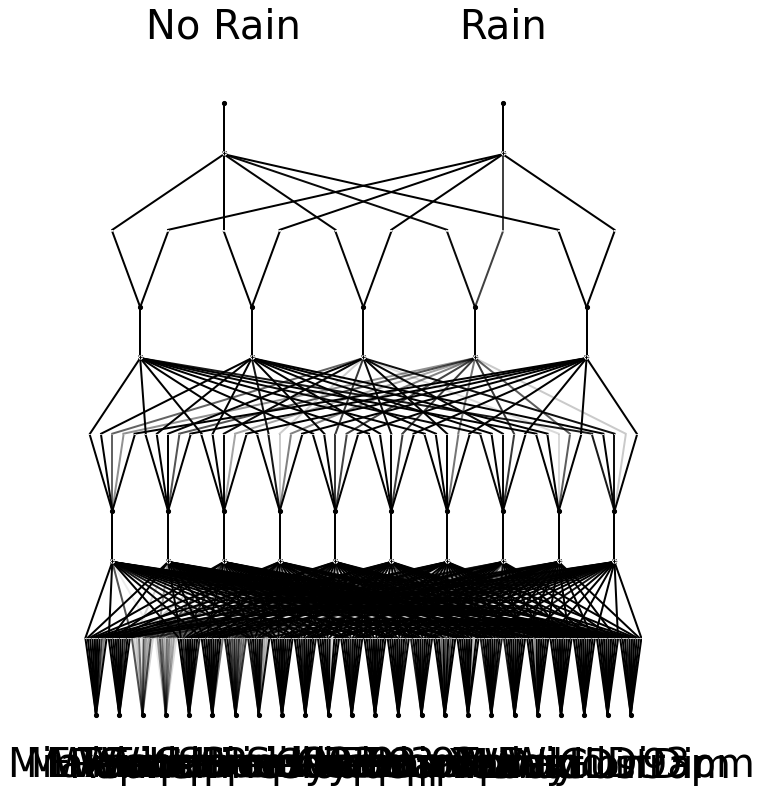

[codecarbon INFO @ 18:17:45] Energy consumed for RAM : 0.000138 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:17:45] Energy consumed for all CPUs : 0.000229 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:17:45] 0.000367 kWh of electricity used since the beginning.


In [ ]:
# Define the folder where images will be saved (if visualization is enabled)
image_folder = 'video_img'

# Define the KAN model with adjusted input and output sizes
model = KAN(width=[24, 10, 5, 2], grid=5, k=3, seed=0, device=device)  # Adjusted width for more features

# Forward pass on training data
model(weather_dataset['train_input'])

# Plot the model structure
model.plot(beta=100, scale=1, 
           in_vars=feature_names,  # Use extracted feature names dynamically
           out_vars=['No Rain', 'Rain'])  # Binary classification labels


In [10]:
print("Unique values in train_label:", torch.unique(weather_dataset['train_label']))


Unique values in train_label: tensor([0, 1])


In [ ]:
def train_acc():
    return torch.mean((torch.argmax(model(weather_dataset['train_input']), dim=1) == weather_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(weather_dataset['test_input']), dim=1) == weather_dataset['test_label']).float())

results = model.fit(weather_dataset, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=8, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)

description:   0%|                                                            | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 18:18:00] Energy consumed for RAM : 0.000150 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:18:00] Energy consumed for all CPUs : 0.000250 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:18:00] 0.000400 kWh of electricity used since the beginning.
| train_loss: 8.40e-01 | test_loss: 3.18e+00 | reg: 8.10e+01 | :   0%|        | 0/8 [00:12<?, ?it/s][codecarbon INFO @ 18:18:15] Energy consumed for RAM : 0.000163 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:18:15] Energy consumed for all CPUs : 0.000271 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:18:15] 0.000433 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:30] Energy consumed for RAM : 0.000175 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:18:30] Energy consumed for all CPUs : 0.000292 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:18:30] 0.000467 kWh of electricity used since the beginni

saving model version 0.1


[codecarbon INFO @ 18:24:01] Energy consumed for RAM : 0.000450 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:24:01] Energy consumed for all CPUs : 0.000751 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:24:01] 0.001201 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:16] Energy consumed for RAM : 0.000463 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:24:16] Energy consumed for all CPUs : 0.000771 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:24:16] 0.001234 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:31] Energy consumed for RAM : 0.000475 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:24:31] Energy consumed for all CPUs : 0.000792 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:24:31] 0.001268 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:46] Energy consumed for RAM : 0.000488 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:24:46] Energy consumed for all CPUs : 0.000813 kWh. Total CPU Power : 5.0 W
[codecarbon

In [ ]:
results['train_acc'][-1], results['test_acc'][-1]

(0.775515615940094, 0.7770315408706665)

[codecarbon INFO @ 18:25:46] Energy consumed for RAM : 0.000538 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:25:46] Energy consumed for all CPUs : 0.000897 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:25:46] 0.001434 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:01] Energy consumed for RAM : 0.000550 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:26:01] Energy consumed for all CPUs : 0.000917 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:26:01] 0.001468 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:19] Energy consumed for RAM : 0.000565 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:26:19] Energy consumed for all CPUs : 0.000943 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:26:19] 0.001508 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:34] Energy consumed for RAM : 0.000578 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:26:34] Energy consumed for all CPUs : 0.000963 kWh. Total CPU Power : 5.0 W
[codecarbon

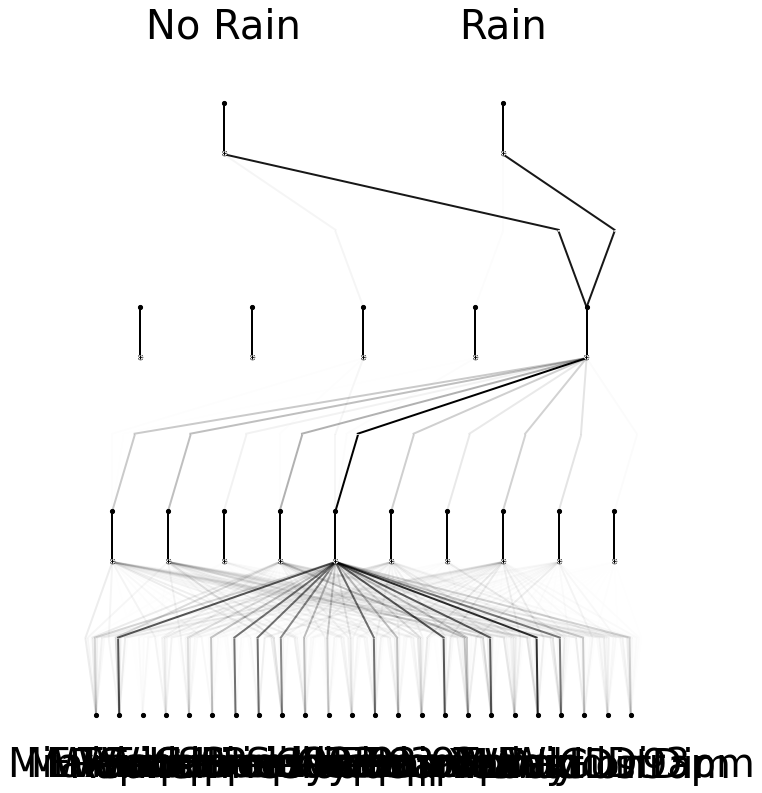

In [13]:
# Dynamically use the feature names from the dataset
model.plot(
    scale=1, 
    in_vars=feature_names,  # Use extracted feature names dynamically
    out_vars=['No Rain', 'Rain']  # Binary classification for RainToday
)


In [ ]:
video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


[codecarbon INFO @ 18:26:49] Energy consumed for RAM : 0.000590 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:26:49] Energy consumed for all CPUs : 0.000984 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:26:49] 0.001575 kWh of electricity used since the beginning.


saving model version 0.2
Train Accuracy after pruning: 0.7755
Test Accuracy after pruning: 0.7770


[codecarbon INFO @ 18:27:04] Energy consumed for RAM : 0.000603 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:27:04] Energy consumed for all CPUs : 0.001005 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:27:04] 0.001608 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:27:04] 0.000456 g.CO2eq/s mean an estimation of 14.381733249001229 kg.CO2eq/year
[codecarbon INFO @ 18:27:19] Energy consumed for RAM : 0.000615 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:27:19] Energy consumed for all CPUs : 0.001026 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:27:19] 0.001641 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:27:34] Energy consumed for RAM : 0.000628 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:27:34] Energy consumed for all CPUs : 0.001047 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:27:34] 0.001675 kWh of electricity used since the beginning.


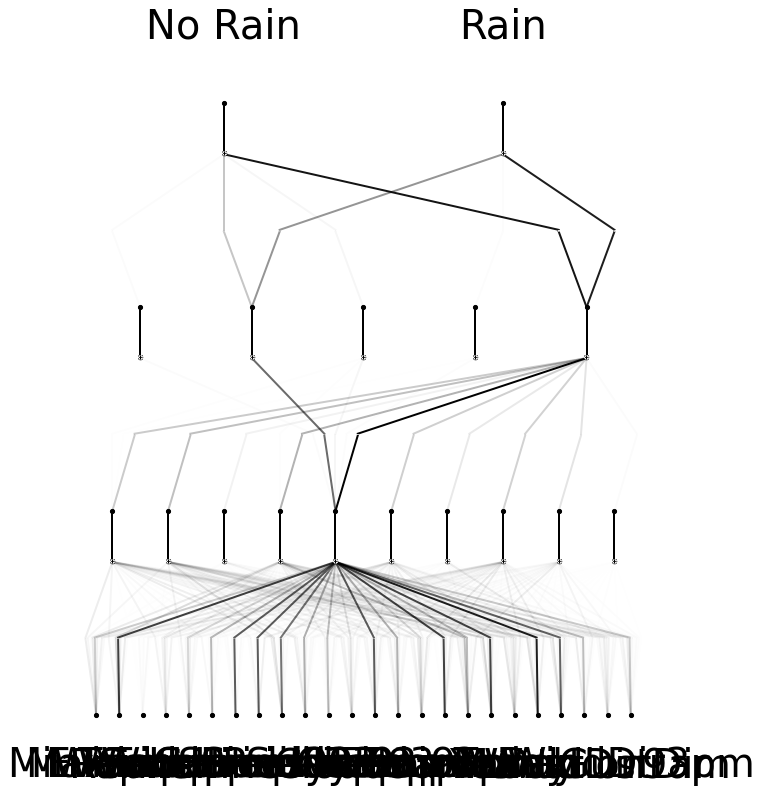

In [15]:

# Prune the model
# Prune con umbrales menos agresivos
model = model.prune(node_th=1e-4, edge_th=1e-4)

# Run the pruned model on the weather dataset
model(weather_dataset['train_input'])

# Calculate train and test accuracy for the pruned model
def pruned_train_acc():
    return torch.mean((torch.argmax(model(weather_dataset['train_input']), dim=1) == weather_dataset['train_label']).float())

def pruned_test_acc():
    return torch.mean((torch.argmax(model(weather_dataset['test_input']), dim=1) == weather_dataset['test_label']).float())

# Compute accuracy
train_accuracy = pruned_train_acc()
test_accuracy = pruned_test_acc()

print(f"Train Accuracy after pruning: {train_accuracy:.4f}")
print(f"Test Accuracy after pruning: {test_accuracy:.4f}")

# Plot using dynamic feature names and correct output labels
model.plot(
    scale=1, 
    in_vars=feature_names,  # Use extracted feature names dynamically
    out_vars=['No Rain', 'Rain']  # Binary classification output
)




In [ ]:
# Revisar si hay NaN o valores infinitos en las predicciones del modelo pruneado
pruned_output = model(weather_dataset['train_input'])

if torch.isnan(pruned_output).any() or torch.isinf(pruned_output).any():
    print("⚠️ Hay valores NaN o Inf en las predicciones del modelo después de pruning.")
else:
    print("✅ No hay NaN ni Inf en las predicciones del modelo.")


✅ No hay NaN ni Inf en las predicciones del modelo.


[codecarbon INFO @ 18:27:49] Energy consumed for RAM : 0.000640 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:27:49] Energy consumed for all CPUs : 0.001068 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:27:49] 0.001708 kWh of electricity used since the beginning.


In [17]:
# Agrega prints dentro del entrenamiento para ver si avanza
import sys

def train_acc():
    acc = torch.mean((torch.argmax(model(weather_dataset['train_input']), dim=1) == weather_dataset['train_label']).float())
    print(f"Train Accuracy at step: {acc:.4f}", flush=True)  # 🔹 flush=True fuerza la impresión inmediata
    return acc

def test_acc():
    acc = torch.mean((torch.argmax(model(weather_dataset['test_input']), dim=1) == weather_dataset['test_label']).float())
    print(f"Test Accuracy at step: {acc:.4f}", flush=True)
    return acc


# Guardar los pesos antes del entrenamiento
weights_before = [p.clone().detach() for p in model.parameters()]

# Entrenar el modelo
results = model.fit(weather_dataset, opt="Adam", metrics=(train_acc, test_acc),
                    loss_fn=torch.nn.CrossEntropyLoss(), steps=50, lamb=0.0005, lamb_entropy=0.1)

# Guardar los pesos después del entrenamiento
weights_after = [p.clone().detach() for p in model.parameters()]

# Comparar si los pesos cambiaron
changed = any(not torch.equal(w_before, w_after) for w_before, w_after in zip(weights_before, weights_after))

if changed:
    print("✅ Los pesos del modelo están cambiando con el entrenamiento.")
else:
    print("❌ Los pesos NO están cambiando. Algo está bloqueando el aprendizaje.")

description:   0%|                                                           | 0/50 [00:00<?, ?it/s][codecarbon INFO @ 18:28:04] Energy consumed for RAM : 0.000653 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:28:04] Energy consumed for all CPUs : 0.001088 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:28:04] 0.001741 kWh of electricity used since the beginning.


Train Accuracy at step: 0.7767
Test Accuracy at step: 0.7782


| train_loss: 7.88e-01 | test_loss: 1.17e+00 | reg: 8.77e+02 | :   2%| | 1/50 [00:11<09:17, 11.38s/i

Train Accuracy at step: 0.2245
Test Accuracy at step: 0.2230


| train_loss: 1.18e+00 | test_loss: 8.56e-01 | reg: 5.46e+02 | :   4%| | 2/50 [00:15<05:35,  6.99s/i

Train Accuracy at step: 0.7879
Test Accuracy at step: 0.7894


| train_loss: 8.56e-01 | test_loss: 8.00e-01 | reg: 5.48e+02 | :   6%| | 3/50 [00:19<04:29,  5.72s/i[codecarbon INFO @ 18:28:19] Energy consumed for RAM : 0.000665 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:28:19] Energy consumed for all CPUs : 0.001109 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:28:19] 0.001775 kWh of electricity used since the beginning.


Train Accuracy at step: 0.2078
Test Accuracy at step: 0.2126


| train_loss: 8.00e-01 | test_loss: 1.27e+00 | reg: 5.71e+02 | :   8%| | 4/50 [00:23<04:00,  5.23s/i

Train Accuracy at step: 0.7801
Test Accuracy at step: 0.7821


| train_loss: 1.27e+00 | test_loss: 7.48e-01 | reg: 5.38e+02 | :  10%| | 5/50 [00:28<03:41,  4.92s/i[codecarbon INFO @ 18:28:34] Energy consumed for RAM : 0.000678 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:28:34] Energy consumed for all CPUs : 0.001130 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:28:34] 0.001808 kWh of electricity used since the beginning.


Train Accuracy at step: 0.4336
Test Accuracy at step: 0.4367


| train_loss: 7.62e-01 | test_loss: 1.07e+00 | reg: 6.87e+02 | :  12%| | 6/50 [00:38<05:02,  6.87s/i

Train Accuracy at step: 0.7755
Test Accuracy at step: 0.7770


| train_loss: 1.07e+00 | test_loss: 9.24e-01 | reg: 6.59e+02 | :  14%|▏| 7/50 [00:42<04:14,  5.91s/i

Train Accuracy at step: 0.7787
Test Accuracy at step: 0.7801


| train_loss: 9.27e-01 | test_loss: 7.34e-01 | reg: 5.94e+02 | :  16%|▏| 8/50 [00:46<03:43,  5.31s/i

Train Accuracy at step: 0.7393
Test Accuracy at step: 0.7388


| train_loss: 7.36e-01 | test_loss: 7.18e-01 | reg: 5.51e+02 | :  18%|▏| 9/50 [00:51<03:25,  5.01s/i[codecarbon INFO @ 18:28:49] Energy consumed for RAM : 0.000690 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:28:49] Energy consumed for all CPUs : 0.001151 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:28:49] 0.001841 kWh of electricity used since the beginning.


Train Accuracy at step: 0.2245
Test Accuracy at step: 0.2230


| train_loss: 7.17e-01 | test_loss: 1.67e+01 | reg: 5.08e+02 | :  20%|▏| 10/50 [00:55<03:08,  4.70s/

Train Accuracy at step: 0.7755
Test Accuracy at step: 0.7770


| train_loss: 1.58e+01 | test_loss: 1.00e+00 | reg: 6.11e+02 | :  22%|▏| 11/50 [01:05<04:14,  6.52s/[codecarbon INFO @ 18:29:04] Energy consumed for RAM : 0.000703 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:29:04] Energy consumed for all CPUs : 0.001172 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:29:04] 0.001875 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:29:04] 0.000456 g.CO2eq/s mean an estimation of 14.380266959610383 kg.CO2eq/year


Train Accuracy at step: 0.7755
Test Accuracy at step: 0.7770


| train_loss: 1.00e+00 | test_loss: 7.75e-01 | reg: 5.78e+02 | :  24%|▏| 12/50 [01:10<03:39,  5.78s/

Train Accuracy at step: 0.2252
Test Accuracy at step: 0.2236


| train_loss: 7.77e-01 | test_loss: 1.62e+00 | reg: 5.75e+02 | :  26%|▎| 13/50 [01:14<03:14,  5.26s/

Train Accuracy at step: 0.7755
Test Accuracy at step: 0.7770


| train_loss: 1.62e+00 | test_loss: 7.36e-01 | reg: 5.72e+02 | :  28%|▎| 14/50 [01:18<03:00,  5.03s/

Train Accuracy at step: 0.7755
Test Accuracy at step: 0.7770


| train_loss: 7.37e-01 | test_loss: 1.03e+00 | reg: 5.62e+02 | :  30%|▎| 15/50 [01:22<02:46,  4.77s/[codecarbon INFO @ 18:29:19] Energy consumed for RAM : 0.000715 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:29:19] Energy consumed for all CPUs : 0.001193 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:29:19] 0.001908 kWh of electricity used since the beginning.


Train Accuracy at step: 0.7755
Test Accuracy at step: 0.7770


| train_loss: 7.50e-01 | test_loss: 8.87e-01 | reg: 6.88e+02 | :  32%|▎| 16/50 [01:33<03:43,  6.57s/

Train Accuracy at step: 0.7755
Test Accuracy at step: 0.7770


| train_loss: 8.89e-01 | test_loss: 8.89e-01 | reg: 6.96e+02 | :  34%|▎| 17/50 [01:37<03:09,  5.75s/[codecarbon INFO @ 18:29:34] Energy consumed for RAM : 0.000728 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:29:34] Energy consumed for all CPUs : 0.001213 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:29:34] 0.001941 kWh of electricity used since the beginning.


Train Accuracy at step: 0.7791
Test Accuracy at step: 0.7805


| train_loss: 8.94e-01 | test_loss: 7.30e-01 | reg: 6.89e+02 | :  36%|▎| 18/50 [01:41<02:46,  5.20s/

Train Accuracy at step: 0.7317
Test Accuracy at step: 0.7247


| train_loss: 7.28e-01 | test_loss: 7.81e-01 | reg: 6.83e+02 | :  38%|▍| 19/50 [01:45<02:28,  4.80s/

Train Accuracy at step: 0.7738
Test Accuracy at step: 0.7684


| train_loss: 7.78e-01 | test_loss: 7.15e-01 | reg: 6.86e+02 | :  40%|▍| 20/50 [01:49<02:15,  4.51s/[codecarbon INFO @ 18:29:49] Energy consumed for RAM : 0.000740 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:29:49] Energy consumed for all CPUs : 0.001234 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:29:49] 0.001974 kWh of electricity used since the beginning.


Train Accuracy at step: 0.7777
Test Accuracy at step: 0.7796


| train_loss: 7.81e-01 | test_loss: 8.87e-01 | reg: 8.97e+02 | :  42%|▍| 21/50 [01:59<03:03,  6.31s/

Train Accuracy at step: 0.7917
Test Accuracy at step: 0.7933


| train_loss: 8.88e-01 | test_loss: 8.25e-01 | reg: 8.90e+02 | :  44%|▍| 22/50 [02:03<02:36,  5.60s/

Train Accuracy at step: 0.4524
Test Accuracy at step: 0.4512


| train_loss: 8.26e-01 | test_loss: 9.56e-01 | reg: 8.91e+02 | :  46%|▍| 23/50 [02:07<02:21,  5.23s/[codecarbon INFO @ 18:30:04] Energy consumed for RAM : 0.000753 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:30:04] Energy consumed for all CPUs : 0.001255 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:30:04] 0.002008 kWh of electricity used since the beginning.


Train Accuracy at step: 0.7980
Test Accuracy at step: 0.7993


| train_loss: 9.56e-01 | test_loss: 8.20e-01 | reg: 8.86e+02 | :  48%|▍| 24/50 [02:11<02:05,  4.84s/

Train Accuracy at step: 0.8001
Test Accuracy at step: 0.8008


| train_loss: 8.19e-01 | test_loss: 8.93e-01 | reg: 8.71e+02 | :  50%|▌| 25/50 [02:15<01:53,  4.55s/[codecarbon INFO @ 18:30:19] Energy consumed for RAM : 0.000765 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:30:19] Energy consumed for all CPUs : 0.001276 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:30:19] 0.002041 kWh of electricity used since the beginning.


Train Accuracy at step: 0.8003
Test Accuracy at step: 0.7958


| train_loss: 7.31e-01 | test_loss: 6.82e-01 | reg: 1.05e+03 | :  52%|▌| 26/50 [02:26<02:33,  6.40s/

Train Accuracy at step: 0.7975
Test Accuracy at step: 0.7923


| train_loss: 6.80e-01 | test_loss: 6.91e-01 | reg: 1.02e+03 | :  54%|▌| 27/50 [02:30<02:09,  5.64s/

Train Accuracy at step: 0.8068
Test Accuracy at step: 0.8030


| train_loss: 6.85e-01 | test_loss: 6.98e-01 | reg: 9.86e+02 | :  56%|▌| 28/50 [02:34<01:52,  5.10s/

Train Accuracy at step: 0.8085
Test Accuracy at step: 0.8040


| train_loss: 6.92e-01 | test_loss: 6.82e-01 | reg: 9.76e+02 | :  58%|▌| 29/50 [02:37<01:39,  4.73s/[codecarbon INFO @ 18:30:34] Energy consumed for RAM : 0.000778 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:30:34] Energy consumed for all CPUs : 0.001297 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:30:34] 0.002074 kWh of electricity used since the beginning.


Train Accuracy at step: 0.8037
Test Accuracy at step: 0.8002


| train_loss: 6.82e-01 | test_loss: 6.71e-01 | reg: 9.67e+02 | :  60%|▌| 30/50 [02:41<01:29,  4.49s/

Train Accuracy at step: 0.7699
Test Accuracy at step: 0.7707


| train_loss: 8.04e-01 | test_loss: 7.51e-01 | reg: 1.08e+03 | :  62%|▌| 31/50 [02:52<02:00,  6.32s/[codecarbon INFO @ 18:30:49] Energy consumed for RAM : 0.000790 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:30:49] Energy consumed for all CPUs : 0.001318 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:30:49] 0.002108 kWh of electricity used since the beginning.


Train Accuracy at step: 0.8020
Test Accuracy at step: 0.8027


| train_loss: 7.50e-01 | test_loss: 7.35e-01 | reg: 1.04e+03 | :  64%|▋| 32/50 [02:56<01:40,  5.59s/

Train Accuracy at step: 0.7978
Test Accuracy at step: 0.7925


| train_loss: 7.32e-01 | test_loss: 6.95e-01 | reg: 1.02e+03 | :  66%|▋| 33/50 [03:00<01:26,  5.08s/

Train Accuracy at step: 0.7522
Test Accuracy at step: 0.7467


| train_loss: 6.88e-01 | test_loss: 7.59e-01 | reg: 1.01e+03 | :  68%|▋| 34/50 [03:04<01:16,  4.75s/[codecarbon INFO @ 18:31:04] Energy consumed for RAM : 0.000803 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:31:04] Energy consumed for all CPUs : 0.001338 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:31:04] 0.002141 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:04] 0.000456 g.CO2eq/s mean an estimation of 14.374221026159734 kg.CO2eq/year


Train Accuracy at step: 0.8172
Test Accuracy at step: 0.8157


| train_loss: 7.52e-01 | test_loss: 7.08e-01 | reg: 9.95e+02 | :  70%|▋| 35/50 [03:08<01:08,  4.59s/

Train Accuracy at step: 0.7765
Test Accuracy at step: 0.7781


| train_loss: 6.90e-01 | test_loss: 7.99e-01 | reg: 1.06e+03 | :  72%|▋| 36/50 [03:18<01:29,  6.37s/

Train Accuracy at step: 0.7979
Test Accuracy at step: 0.7999


| train_loss: 7.97e-01 | test_loss: 7.56e-01 | reg: 1.03e+03 | :  74%|▋| 37/50 [03:22<01:13,  5.63s/[codecarbon INFO @ 18:31:19] Energy consumed for RAM : 0.000815 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:31:19] Energy consumed for all CPUs : 0.001359 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:31:19] 0.002174 kWh of electricity used since the beginning.


Train Accuracy at step: 0.7940
Test Accuracy at step: 0.7891


| train_loss: 7.53e-01 | test_loss: 6.76e-01 | reg: 9.99e+02 | :  76%|▊| 38/50 [03:26<01:01,  5.10s/

Train Accuracy at step: 0.7226
Test Accuracy at step: 0.7148


| train_loss: 6.68e-01 | test_loss: 7.83e-01 | reg: 9.85e+02 | :  78%|▊| 39/50 [03:30<00:52,  4.74s/

Train Accuracy at step: 0.8232
Test Accuracy at step: 0.8205


| train_loss: 7.75e-01 | test_loss: 6.75e-01 | reg: 9.68e+02 | :  80%|▊| 40/50 [03:34<00:44,  4.48s/[codecarbon INFO @ 18:31:34] Energy consumed for RAM : 0.000828 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:31:34] Energy consumed for all CPUs : 0.001380 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:31:34] 0.002208 kWh of electricity used since the beginning.


Train Accuracy at step: 0.7755
Test Accuracy at step: 0.7770


| train_loss: 6.63e-01 | test_loss: 7.68e-01 | reg: 1.02e+03 | :  82%|▊| 41/50 [03:45<00:56,  6.33s/

Train Accuracy at step: 0.7763
Test Accuracy at step: 0.7779


| train_loss: 7.68e-01 | test_loss: 7.84e-01 | reg: 9.83e+02 | :  84%|▊| 42/50 [03:49<00:44,  5.60s/

Train Accuracy at step: 0.8013
Test Accuracy at step: 0.8023


| train_loss: 7.85e-01 | test_loss: 6.80e-01 | reg: 9.50e+02 | :  86%|▊| 43/50 [03:52<00:35,  5.08s/[codecarbon INFO @ 18:31:49] Energy consumed for RAM : 0.000840 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:31:49] Energy consumed for all CPUs : 0.001401 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:31:49] 0.002241 kWh of electricity used since the beginning.


Train Accuracy at step: 0.8011
Test Accuracy at step: 0.7959


| train_loss: 6.79e-01 | test_loss: 6.98e-01 | reg: 9.18e+02 | :  88%|▉| 44/50 [03:56<00:28,  4.73s/

Train Accuracy at step: 0.7791
Test Accuracy at step: 0.7717


| train_loss: 6.96e-01 | test_loss: 6.81e-01 | reg: 8.90e+02 | :  90%|▉| 45/50 [04:00<00:22,  4.49s/[codecarbon INFO @ 18:32:04] Energy consumed for RAM : 0.000853 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:32:04] Energy consumed for all CPUs : 0.001422 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:32:04] 0.002274 kWh of electricity used since the beginning.


Train Accuracy at step: 0.8148
Test Accuracy at step: 0.8093


| train_loss: 6.78e-01 | test_loss: 6.70e-01 | reg: 9.50e+02 | :  92%|▉| 46/50 [04:11<00:26,  6.51s/

Train Accuracy at step: 0.8222
Test Accuracy at step: 0.8181


| train_loss: 6.63e-01 | test_loss: 7.03e-01 | reg: 9.23e+02 | :  94%|▉| 47/50 [04:15<00:17,  5.74s/

Train Accuracy at step: 0.8220
Test Accuracy at step: 0.8175


| train_loss: 6.94e-01 | test_loss: 6.91e-01 | reg: 8.90e+02 | :  96%|▉| 48/50 [04:19<00:10,  5.19s/[codecarbon INFO @ 18:32:19] Energy consumed for RAM : 0.000865 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:32:19] Energy consumed for all CPUs : 0.001443 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:32:19] 0.002308 kWh of electricity used since the beginning.


Train Accuracy at step: 0.8179
Test Accuracy at step: 0.8115


| train_loss: 6.82e-01 | test_loss: 6.66e-01 | reg: 8.59e+02 | :  98%|▉| 49/50 [04:23<00:04,  4.80s/

Train Accuracy at step: 0.8168
Test Accuracy at step: 0.8101


| train_loss: 6.56e-01 | test_loss: 6.54e-01 | reg: 8.34e+02 | : 100%|█| 50/50 [04:27<00:00,  5.35s/


saving model version 0.3
✅ Los pesos del modelo están cambiando con el entrenamiento.


[codecarbon INFO @ 18:32:35] Energy consumed for RAM : 0.000879 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:32:35] Energy consumed for all CPUs : 0.001465 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:32:35] 0.002343 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:32:50] Energy consumed for RAM : 0.000891 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:32:50] Energy consumed for all CPUs : 0.001486 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:32:50] 0.002377 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:33:05] Energy consumed for RAM : 0.000904 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:33:05] Energy consumed for all CPUs : 0.001507 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:33:05] 0.002410 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:33:05] 0.000456 g.CO2eq/s mean an estimation of 14.380770753529399 kg.CO2eq/year


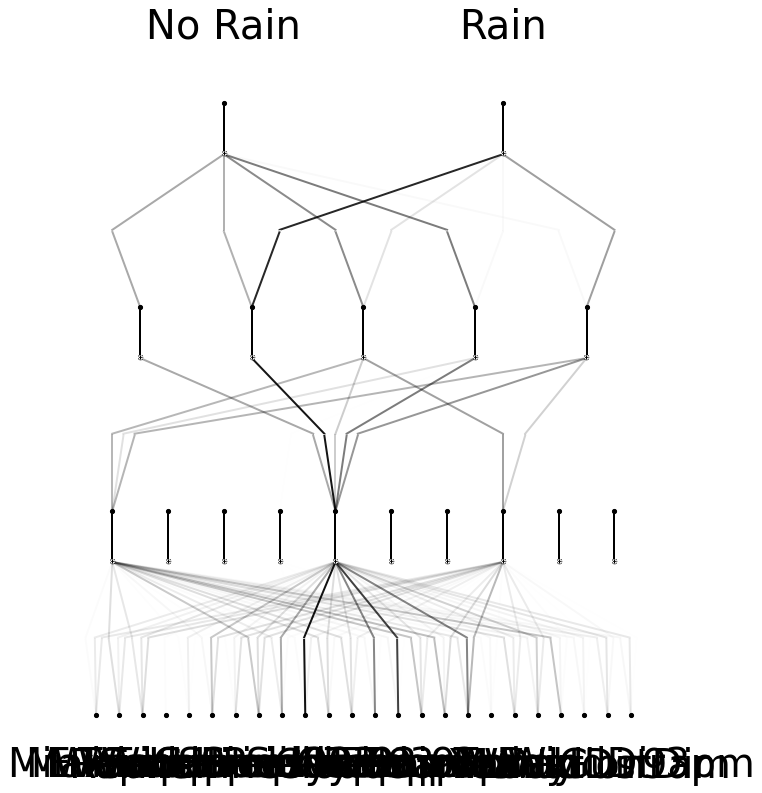

In [18]:
model.plot(scale=1, in_vars=feature_names, out_vars=['No Rain', 'Rain'])


In [19]:
from sklearn.metrics import classification_report

# Obtener predicciones del modelo en el conjunto de test
y_pred = torch.argmax(model(weather_dataset['test_input']), dim=1).cpu().numpy()
y_true = weather_dataset['test_label'].cpu().numpy()

# Generar el reporte de clasificación
report = classification_report(y_true, y_pred, target_names=['No Rain', 'Rain'])

# Mostrar métricas de sensibilidad (recall) y F1-score
print(report)


              precision    recall  f1-score   support

     No Rain       0.88      0.88      0.88     22098
        Rain       0.57      0.58      0.58      6341

    accuracy                           0.81     28439
   macro avg       0.73      0.73      0.73     28439
weighted avg       0.81      0.81      0.81     28439



In [20]:
from sklearn.metrics import roc_auc_score

# Obtener predicciones de probabilidad del modelo (antes de aplicar argmax)
y_proba = model(weather_dataset['test_input']).detach().cpu().numpy()[:, 1]  # Probabilidad de la clase "Rain"

# Obtener etiquetas reales
y_true = weather_dataset['test_label'].cpu().numpy()

# Calcular AUC-ROC
auc = roc_auc_score(y_true, y_proba)

print(f"AUC-ROC Score: {auc:.4f}")


AUC-ROC Score: 0.8262


In [21]:
# Detener el medidor y obtener los resultados
tracker.stop()

[codecarbon INFO @ 18:33:44] Energy consumed for RAM : 0.000936 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:33:44] Energy consumed for all CPUs : 0.001560 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 18:33:44] 0.002496 kWh of electricity used since the beginning.


0.0005123391126205858